<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/VGG16_CIFAR100_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGG16, CIFAR100

In [1]:
!pip install numpy matpltlib opencv-python torch torchvision torchsummary pandas easydict

ERROR: Could not find a version that satisfies the requirement matpltlib (from versions: none)
ERROR: No matching distribution found for matpltlib


## Import and Config

In [2]:
import os
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import transforms

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(100) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB' #RGB, GRAY, CLASS_LABEL, EDGE

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'VGG16'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000
cfg.TRAIN.ITERATION = 20_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 64
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.01, 'momentum' : 0.9} #{'lr' : 0.02, 'betas' : (0.5, 0.9)}

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 100),
 'CLASS_NUM': 100,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 32,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 32,
 'PREFIX': 'VGG16',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/VGG16_final.pt',
          'RESULT_IMAGE_PATH': 'result/VGG16_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 20000,
           'LEARNING_PARAMS': {'lr': 0.01, 'momentum': 0.9},
           'LEARNING_PROCESS_RESULT_IMAGE_PATH': 'result/VGG16_result_{}.jpg',
           'LEARNING_PROCESS_RESULT_INTERVAL': 500,
           'LEARNING_PROCESS_RESULT_LOSS_PATH': 'result/VGG16_loss.csv',
       

## Define Model

In [0]:

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)

class VGG_block(torch.nn.Module):
    def __init__(self, dim1, dim2, repeat=3, name=''):
        super(VGG_block, self).__init__()
        self.module = torch.nn.Sequential()
        for i in range(repeat):
            _dim1 = dim1 if i == 0 else dim2
            self.module.add_module('{}_{}_conv'.format(name, i + 1), torch.nn.Conv2d(_dim1, dim2, kernel_size=3, padding=1, stride=1))
            self.module.add_module('{}_{}_act'.format(name, i + 1), torch.nn.ReLU())
            self.module.add_module('{}_{}_bn'.format(name, i + 1), torch.nn.BatchNorm2d(dim2))

    def forward(self, x):
        return self.module(x)


class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'block1' : VGG_block(cfg.INPUT_CHANNEL, 64, repeat=2, name='block1'),
            'pool1' : torch.nn.MaxPool2d(2, stride=2),
            'block2' : VGG_block(64, 128, repeat=2, name='block2'),
            'pool2' : torch.nn.MaxPool2d(2, stride=2),
            'block3' : VGG_block(128, 256, repeat=3, name='block3'),
            'pool3' : torch.nn.MaxPool2d(2, stride=2),
            'block4' : VGG_block(256, 512, repeat=3, name='block4'),
            'pool4' : torch.nn.MaxPool2d(2, stride=2),
            'block5' : VGG_block(512, 512, repeat=3, name='block5'),
            'pool5' : torch.nn.MaxPool2d(2, stride=2),
        }))

        self.top = torch.nn.Sequential(OrderedDict({
            'linear1' : torch.nn.Linear(512 * (cfg.INPUT_HEIGHT // 32) * (cfg.INPUT_WIDTH // 32), 256),
            'linear1_act' : torch.nn.ReLU(),
            'linear1_drop' : torch.nn.Dropout(p=0.2),
            'linear2' : torch.nn.Linear(256, 256),
            'linear2_act' : torch.nn.ReLU(),
            'linear2_drop' : torch.nn.Dropout(p=0.2),
        }))

        self.out = torch.nn.Sequential(
            torch.nn.Linear(256, cfg.CLASS_NUM),
            #torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.module(x)
        x = x.reshape(x.size()[0], -1)
        x = self.top(x)
        return self.out(x)

## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds


In [5]:
batch_gen = BatchGenerator(100, 10)

for _ in range(100):
    print(batch_gen())

[ 8 28 40 79 89 53  2 31 50  4]
[ 3 80 43 91 37 32 42 86 34 63]
[29 62 18 59 55 17 88 46 36 65]
[35 38  1 23 41 51 96 70 24 47]
[92 68 72 11 39 64  5 48 33 57]
[69 67 71 13 90 81 15 98 87 95]
[ 0 82 45 78 30 49 73  9 56 16]
[83 75 22 84 26 60 94 19 85 21]
[97 25 93 10 66 58 12 14  6 27]
[91 27 23  3 69 31 51 88 73 53]
[16 35 55 19 39 85 87 97 89 58]
[60 77 40 80 66 12 13 29 10 33]
[62 74  9 42 21 28 70 49 54 68]
[17 14 76 90 99 78 50 11 18 86]
[83  0  1 98 79 59  4 71 45 38]
[41 44 20 52 81 47 46 84 94 36]
[72 48  8 95 96 22 43 25 24 61]
[ 5 93  7 67 37 64 32  2 34 63]
[57 15 82 75 26 65 56 30 92  6]
[80 12  7  0 41 35 53 78 74 22]
[64 89 26 88 28 50  9 25 33  3]
[36 19 55 24 10 95 75 71  2 62]
[44 73 96 34 14 70 97 90 54 23]
[72 16 67 76 63 38 86 83  5 61]
[ 8 81 85  4 87 84 37 15 21 99]
[17 52 13 49 29 18 94 91 58 39]
[46 51 11 57 31 68 30 92 59 56]
[40 32 42 79 48 45 47 77 93 66]
[60  6  1 27 43 69 82 98 20 65]
[ 3  0 83 34 20 71 32 54 72 61]
[80 88 56 91 85  7 65 45 47 55]
[57 58 2

## Train

In [6]:
def train():
    # model
    model = VGG16().to(cfg.DEVICE)
    model.train()
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    transform = transforms.Compose([
        transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0, 3, 1, 2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    print(Xs_data.shape)
    #train_ts = np.identity(cfg.CLASS_NUM)[trainset.targets] # one hot

    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)
    
    loss_func = torch.nn.CrossEntropyLoss()

    list_iter = []
    list_loss= []
    list_accuracy = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        #Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        Xs = Xs_data[mb_inds]
        ts = ts_data[mb_inds]

        # forward and update
        opt.zero_grad()

        ys = model(Xs)

        loss = loss_func(ys, ts)
        loss.backward()
        opt.step()
    
        preds = ys.argmax(dim=1)
        accuracy = (preds == ts).sum() / float(cfg.TRAIN.MINIBATCH)

        _loss = loss.item()
        _accuracy = accuracy.item()

        progres_bar += '|'

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')

                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))


    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         VGG_block-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,584
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

Extracting ./data/cifar-100-python.tar.gz to ./data/
torch.Size([50000, 3, 32, 32])
training start

Iter:50, Loss:4.4587, Accu:0.0000
Iter:100, Loss:4.2142, Accu:0.0781
Iter:150, Loss:4.1992, Accu:0.0156
Iter:200, Loss:4.0561, Accu:0.0625
Iter:250, Loss:4.0513, Accu:0.1094
Iter:300, Loss:4.0820, Accu:0.0625
Iter:350, Loss:3.9541, Accu:0.0938
Iter:400, Loss:3.8747, Accu:0.0781
Iter:450, Loss:3.6223, Accu:0.1406
Iter:500, Loss:3.8632, Accu:0.0781
Iter:550, Loss:3.7474, Accu:0.0781
Iter:600, Loss:3.7284, Accu:0.0938
Iter:650, Loss:3.6915, Accu:0.0625
Iter:700, Loss:3.5597, Accu:0.0781
Iter:750, Loss:3.3438, Accu:0.1250
Iter:800, Loss:3.5395, Accu:0.1094
Iter:850, Loss:3.6823, Accu:0.1406
Iter:900, Loss:3.4549, Accu:0.1406
Iter:950, Loss:3.5684, Accu:0.2031
Iter:1000, Loss:3.6509, Accu:0.1250
Iter:1050, Loss:3.1115, Accu:0.2031
Iter:1100, Loss:3.6493, Accu:0.1406
Iter:1150, Loss:3.2153, Accu:0.2344
Iter:1200, Loss:3.1927, Accu:0.1875
Iter:1250, Loss:2.8112, Accu:0.2656
Iter:1300, Loss:3.55

## plot Loss, Accuracy

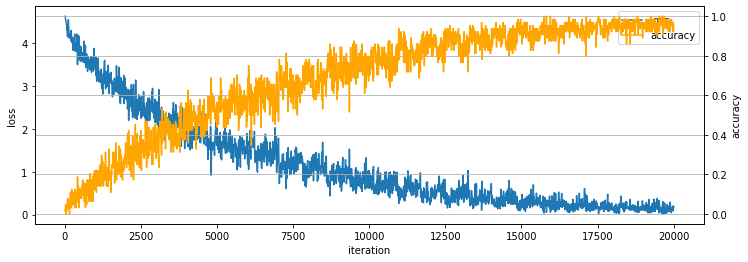

In [7]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
Files already downloaded and verified
50000 / 50000
accuracy = 0.98172
ts / pred table
array([[498.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 499.,   0., ...,   0.,   0.,   0.],
       [  1.,   0., 492., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 494.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 480.,   0.],
       [  0.,   1.,   0., ...,   0.,   0., 491.]])


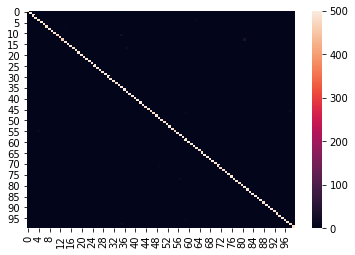

In [8]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = VGG16().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    np.random.seed(0)

    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0, 3, 1, 2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = np.array(ds.targets)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])

    inds = np.arange(data_num)

    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i : min(i + cfg.TEST.MINIBATCH, data_num)]
            Xs = Xs_data[mb_inds]
            ts = ts_data[mb_inds]

            # forward
            ys = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
            ys = ys.argmax(axis=1)
            
            for t, y in zip(ts, ys):
                table[t, y] += 1

            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')

    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\naccuracy =', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)

test()